## check or install cuda version, e.g.,conda install cudatoolkit=10.1
```
##pip install cellpose
pip uninstall mxnet-mkl
pip uninstall mxnet
pip install mxnet-cu101 
conda install -c anaconda ipython
```
### imjoy
```
pip install imjoy
pip install -U imjoy-jupyter-extension

```

#### This is a magic command to run using imjoy api without export ImjoyPlugin, after first run
```
await asyncio.ensure_future(run())
```

In [13]:
# use cellpose==0.1.22
import os
from glob import glob
import numpy as np
import mxnet as mx
from cellpose import models, utils, plot
from imageio import imread
from skimage import segmentation
from scipy import ndimage as ndi
from skimage.transform import rescale
import cv2
from PIL import Image

class CellposeMaskGen:
    def __init__(
        self,
        cell_img, # this would be img array directly
        nuclei_img, # this would be img array directly
        # mask_image_path
        ):
        self.device = mx.gpu()
        img = np.append([nuclei_img], [cell_img], axis=0)
        self.img = img.transpose(1, 2, 0)
        #self.mask_image_path = mask_image_path
        self.model = models.Cellpose(self.device, model_type='cyto')

    def cellpose_mask_gen(self, scale_factor=0.25):
        def _fill_holes(image):
            """fill_holes for labelled image, with a unique number"""
            boundaries = segmentation.find_boundaries(image)
            image = np.multiply(image, np.invert(boundaries))
            image = ndi.binary_fill_holes(image > 0)
            image = ndi.label(image)[0]
            return np.asarray(image, dtype=np.uint16)
    
        #model = models.Cellpose(mx.gpu(), model_type='cyto')
        #img = imread(image_path)
        try:
            assert self.img.shape==(2048, 2048, 2)
            #print(img.shape)
        except AssertionError:
            if self.img.shape[0]%2:
                return f'img is with image shape of {self.img.shape}'
            else:
                scale_factor = 0.5
        #img = img.reshape([2048, 2048, 1])
        self.img = rescale(self.img, scale_factor, multichannel=True)
        imgs= [self.img]
        # second channel denotes nucleus channel.
        # channels = [cytoplasm, nucleus]
        # [2, 1] denotes the channle 1 and channel 0,
        # respectively for cytoplasm and nucleus
        masks, flows, styles, diams = self.model.eval(
            imgs, rescale=None, channels=[[2,1]])
        mask = masks[0].astype('uint16')
        #print(scale_factor)
        shape = (
            int(mask.shape[0]/scale_factor),
            int(mask.shape[1]/scale_factor)
        )
        #print(shape)
        mask1 = cv2.resize(
            mask, shape, interpolation=cv2.INTER_AREA,).astype('uint16')
        return _fill_holes(mask1)

    def save_mask(self):
        mask = self.cellpose_mask_gen()
        if isinstance(mask, str):
            print(mask)
        else:
            return mask
            #pass
            #Image.fromarray(mask).save(
            #    self.mask_image_path, bits=16)

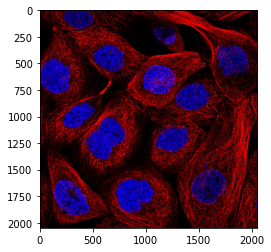

In [15]:
import imageio
from matplotlib import pyplot as plt
image = imread('example.jpg')
plt.imshow(image)
plt.show()

100%|██████████| 1/1 [00:04<00:00,  4.51s/it]


estimated cell diameters for all images


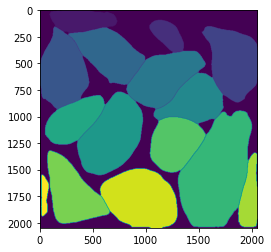

In [16]:
cell_img = np.asarray(image[:,:,0])
nuclei_img = np.asarray(image[:,:,2])
mask = CellposeMaskGen(cell_img, nuclei_img).cellpose_mask_gen()
#plt.imshow(nuclei_img)
plt.imshow(mask)
plt.show()

In [18]:
from imjoy import api
import numpy as np
import asyncio
import imageio

class ImJoyPlugin():
    async def setup(self):
        pass

    async def run(self, ctx):
        viewer = await api.showDialog(src="https://kaibu.org/#/app")

        #image = np.random.randint(0, 255, [500, 500], dtype='uint8')
        image = imageio.imread('example.jpg')
        cell_img = np.asarray(image[:,:,0])
        nuclei_img = np.asarray(image[:,:,2])
        #mask = CellposeMaskGen(cell_img, nuclei_img).cellpose_mask_gen()
        # view image
        await viewer.view_image(image, type="itk-vtk", name="random pixels")

        #points = np.random.randint(0, 2048, [100, 2], dtype='uint16')
        #layer = await viewer.add_points(points, face_color="red")

        async def say_hello():
            await api.alert('Hello!')
        async def generate_cellpose_mask():
            #await api.alert("call for mask")
            mask = CellposeMaskGen(cell_img, nuclei_img).cellpose_mask_gen()
            #api.alert(image.shape)
            mask = np.array(mask > 0, dtype='uint8')*85
            image[:,:,1] = mask
            await viewer.view_image(image, type="itk-vtk", name="random pixels")
        async def get_geojson_features():
            # get the annotation in geojson format
            features = await layer.get_features()
            await api.alert(str(features))

        await viewer.set_ui({"title": "Utilities",
                             "elements": [
                                 {"_rintf": True,
                                  "type": "button",
                                  "label": "Load Image",
                                  "callback": say_hello
                                 },
                                 {"_rintf": True,
                                  "type": "button",
                                  "label": "Predict Cell Masks",
                                  "callback": generate_cellpose_mask
                                 },

                             ]
                            })
api.export(ImJoyPlugin())

<IPython.core.display.Javascript object>